# Xgboost Demo

In [13]:
%matplotlib inline

from sklearn.datasets import make_classification
import numpy as np
import pandas as pd 
import xgboost as xgb 
from matplotlib import pylab as plt 
import seaborn as sns

## Dataset

In [11]:
X, y = make_classification(
    1000,
    n_features=20,
    n_informative=2,
    n_redundant=2,
    n_classes=2,
    random_state=0)

df = pd.DataFrame(np.hstack((X, y[:, None])), columns=range(20) + ["class"])

## Train & Evaluate

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 34



Model Report
Accuracy : 0.984
AUC Score (Train): 0.997336


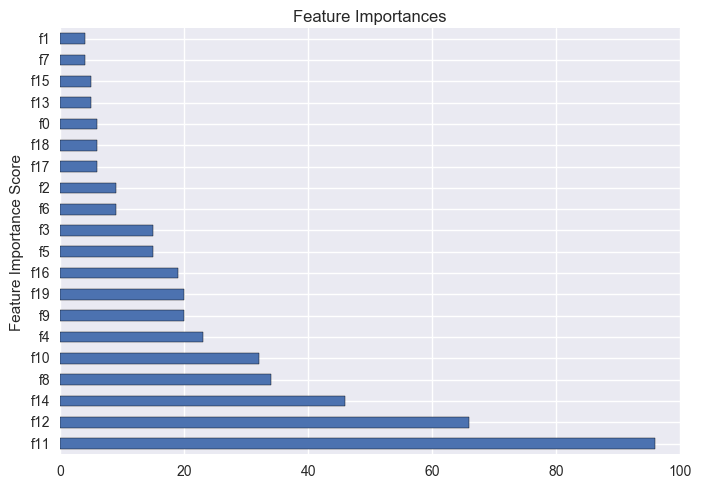

In [22]:
# sklearn api of xgboost 
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV


def model_fit(alg,
              train_X,
              train_y,
              use_train_cv=True,
              cv_folds=5,
              early_stopping_rounds=50):
    """
    """
    if use_train_cv:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train_X, label=train_y)
        cvresult = xgb.cv(xgb_param,
                          xgtrain,
                          num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,
                          metrics=['auc'],
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(train_X, train_y, eval_metric='auc')

    #Predict training set:
    dtrain_predictions = alg.predict(train_X)
    dtrain_predprob = alg.predict_proba(train_X)[:, 1]

    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(train_y,
                                                     dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(train_y,
                                                          dtrain_predprob)

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(
        ascending=False)
    feat_imp.plot(kind='barh', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


xgb_clf = XGBClassifier(
    learning_rate=0.01,
    n_estimators=300,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=16,
    scale_pos_weight=1,
    seed=27)

model_fit(xgb_clf, X, y, use_train_cv=True)

## Plot

In [9]:
def plot_feature_importance(bst, f_index_map_path, out_path):
    """
    绘制xgboost模型特征重要性柱形图
    """
    feature_name_list = ceate_feature_map(f_index_map_path, out_path)
    importance = bst.get_fscore(fmap=out_path)
    importance = sorted(
        importance.items(), key=operator.itemgetter(1), reverse=False)
    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    fig = plt.figure()
    df.plot(
        kind='barh', x='feature', y='fscore', legend=False, figsize=(9, 22))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')
    plt.gcf().savefig('feature_importance_xgb.png', dpi=fig.dpi)

In [5]:
def save_bst_tree(bst, tree_num=0, out_path='img/'):
    """
    将指定序号提升树绘成图形并保存在目录out_path下
    """
    graph = xgb.to_graphviz(bst, tree_num)
    tree_file = graph.render(filename=out_path+str(tree_num))
    return tree_file 

## DEMO

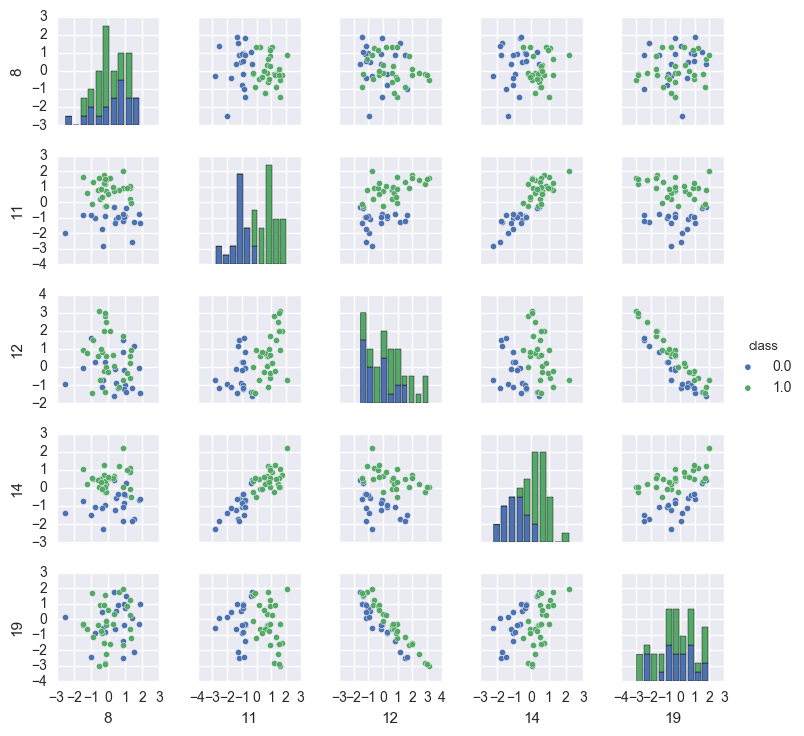

In [17]:
_ = sns.pairplot(df[:50], vars=[8, 11, 12, 14, 19], hue="class", size=1.5) 

In [23]:
save_bst_tree(bst)

NameError: name 'bst' is not defined